In [2]:
from pathlib import Path
import re
from collections import Counter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Path to your local copy
# DATA_PATH = Path("data/raw/TinyStories/TinyStories-train.txt")
DATA_PATH = Path("..") / "data" / "raw" / "TinyStories" / "TinyStories-train.txt"


# Regular expression to recognize the <|endoftext|> delimiter
DELIM_RE = re.compile(r"\s*<\|endoftext\|\>\s*", flags=re.IGNORECASE)


In [3]:
# Rolling through the huge .txt file without loading it all into memory (doing 1MB at a time)

def stream_stories(path: Path, chunk_size: int = 1024 * 1024):
    """
    Yield one story at a time by splitting on <|endoftext|>.
    Reads in small chunks so we never hold the whole file in memory.
    """
    buf = ""
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            buf += chunk
            parts = DELIM_RE.split(buf)
            # all but the last are complete stories
            for s in parts[:-1]:
                s = s.strip()
                if s:
                    yield s
            buf = parts[-1]  # keep the tail for the next read
        # flush the remainder
        tail = buf.strip()
        if tail:
            yield tail


In [4]:
# Quick sanity checks through first 3 stories

for i, story in zip(range(3), stream_stories(DATA_PATH)):
    print(f"--- Story {i} ---")
    print(story[:400], "...\n")


--- Story 0 ---
One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.
Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."
Toge ...

--- Story 1 ---
Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.
One day, Beep was driving in the park when he saw a big tree. The tree had many leaves that were falling. Beep liked how the leaves fall and wanted to play with them. Beep drove under the tree and watched the l ...

--- Story 2 ---
One day, a little fish named Fin was swimming near the shore. He saw a big crab and wanted to be friends. "Hi, I am Fin. Do you want to play

In [5]:
from tqdm import auto as tqa
tqdm = tqa.tqdm


def count_stories_with_byte_progress(path: Path, chunk_size: int = 1024 * 1024):
    total_bytes = path.stat().st_size
    count = 0
    buf = ""
    with path.open("r", encoding="utf-8", errors="ignore") as f, \
         tqdm(total=total_bytes, unit="B", unit_scale=True, desc="Reading file") as pbar:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            buf += chunk
            pbar.update(len(chunk))
            parts = DELIM_RE.split(buf)
            count += sum(1 for s in parts[:-1] if s.strip())
            buf = parts[-1]
        if buf.strip():
            count += 1
    return count

story_count = count_stories_with_byte_progress(DATA_PATH)
print(f"Total stories: {story_count:,}")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Reading file: 100%|█████████▉| 1.92G/1.92G [00:26<00:00, 72.2MB/s]

Total stories: 2,119,489


In [7]:
# Counting the amount of <|endoftext|> markers in the file 

def count_delims(path: Path, needle="<|endoftext|>"):
    total = 0
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), ""):
            total += chunk.lower().count(needle)
    return total

raw_delims = count_delims(DATA_PATH)
print(f"Raw <|endoftext|> markers: {raw_delims:,}")


Raw <|endoftext|> markers: 2,119,697


# Analyzing first words of stories

In [8]:
# strip quotes/punctuation then grab the first alphabetical word
FIRST_WORD_RE = re.compile(r"^[\s\"'\-–—\(\[\{]*([A-Za-z]+)")

def first_word(text: str) -> str | None:
    m = FIRST_WORD_RE.match(text)
    if not m:
        return None
    return m.group(1).lower()


In [9]:
first_word_counts = Counter()
for story in tqdm(stream_stories(DATA_PATH), desc="Counting first words"):
    w = first_word(story)
    if w:
        first_word_counts[w] += 1

len(first_word_counts), sum(first_word_counts.values())


Counting first words: 2119489it [00:27, 77208.51it/s]


(2880, 2119416)

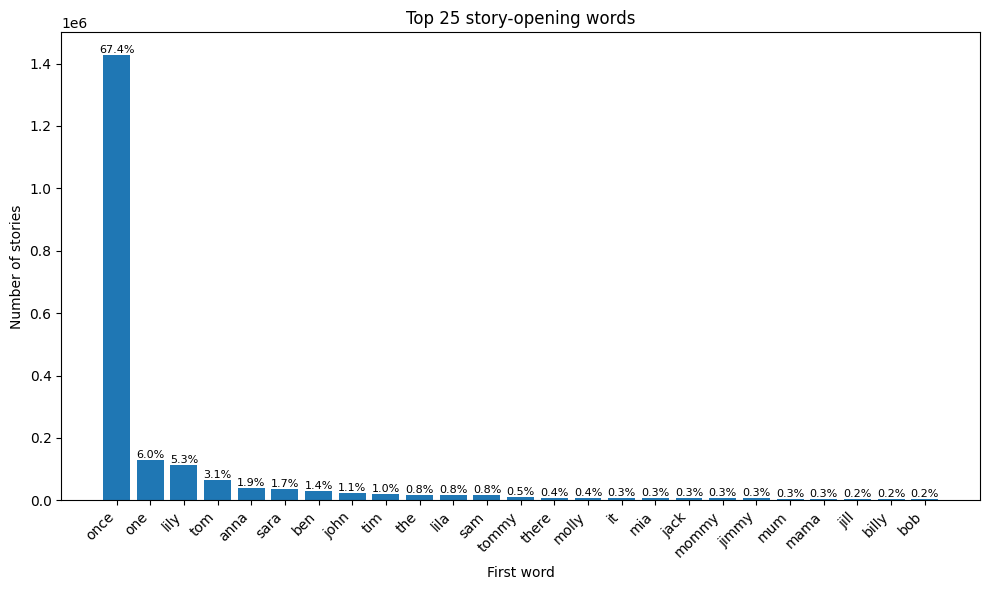

In [11]:
TOP_N = 25  # number of bars to plot in First Word barplot
top_items = first_word_counts.most_common(TOP_N)

words  = [w for w, c in top_items]
counts = [c for w, c in top_items]

total_stories = sum(first_word_counts.values())
percentages = [c / total_stories * 100 for c in counts]

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(words)), counts)
plt.xticks(range(len(words)), words, rotation=45, ha="right")
plt.title(f"Top {TOP_N} story-opening words")
plt.xlabel("First word")
plt.ylabel("Number of stories")

# annotate each bar with its percentage
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()


Extension that classifies openings

In [12]:
import re
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
# Build a regex that tolerates quotes/brackets/dashes at the very start
LEAD = r'^[\s"\'\-–—\(\[\{]*'
# Specific → general order to avoid double counting
RE_OUAT = re.compile(LEAD + r'(once\s+upon\s+a\s+time)(,)?\b', re.IGNORECASE)
RE_ONE_DAY = re.compile(LEAD + r'(one\s+day)(,)?\b', re.IGNORECASE)
RE_ONCE = re.compile(LEAD + r'(once)(,)?\b', re.IGNORECASE)
RE_ONE = re.compile(LEAD + r'(one)(,)?\b', re.IGNORECASE)

def categorize_opening(text: str):
    """
    Returns (category, comma_flag) where comma_flag is:
      'with comma', 'without comma', or None (when not applicable).
    Categories: 'once upon a time', 'one day', 'once', 'one', 'other'.
    """
    for cat, rx in [
        ('once upon a time', RE_OUAT),
        ('one day', RE_ONE_DAY),
        ('once', RE_ONCE),
        ('one', RE_ONE),
    ]:
        m = rx.search(text)
        if m:
            comma_flag = 'with comma' if (m.group(2) is not None) else 'without comma'
            # Only OUAT gets explicit comma breakdown in the report;
            # for others we keep the info but won't always chart it.
            return cat, comma_flag if cat == 'once upon a time' else None
    return 'other', None

In [14]:
# Count categories over all stories 

category_counts = Counter()
ouat_comma_counts = Counter()   # only for "once upon a time"
N = 0

for story in tqdm(stream_stories(DATA_PATH), desc="Classifying openings"):
    N += 1
    cat, comma_flag = categorize_opening(story)
    category_counts[cat] += 1
    if cat == 'once upon a time':
        ouat_comma_counts[comma_flag] += 1

Classifying openings: 2119489it [00:43, 48849.53it/s]


In [16]:
# Summery of tablea
cat_df = (
    pd.DataFrame(
        {'category': list(category_counts.keys()),
         'count': list(category_counts.values())}
    )
    .assign(percent=lambda d: d['count'] / N * 100)
    .sort_values('count', ascending=False)
    .reset_index(drop=True)
)

ouat_total = ouat_comma_counts['with comma'] + ouat_comma_counts['without comma']
ouat_df = (
    pd.DataFrame(
        {'comma': ['with comma', 'without comma'],
         'count': [ouat_comma_counts['with comma'], ouat_comma_counts['without comma']]}
    )
    .assign(percent=lambda d: (d['count'] / ouat_total * 100) if ouat_total else 0.0)
)


In [18]:
print("\n=== Opening categories (overall) ===")
print(cat_df.to_string(index=False, formatters={'percent': '{:.2f}%'.format}))

print("\n=== 'Once upon a time' — comma vs no comma ===")
if ouat_total:
    print(ouat_df.to_string(index=False, formatters={'percent': '{:.2f}%'.format}))
else:
    print("No stories starting with 'once upon a time' found.")



=== Opening categories (overall) ===
        category   count percent
once upon a time 1260020  59.45%
           other  562834  26.56%
            once  168518   7.95%
         one day  118625   5.60%
             one    9492   0.45%

=== 'Once upon a time' — comma vs no comma ===
        comma   count percent
   with comma      14   0.00%
without comma 1260006 100.00%


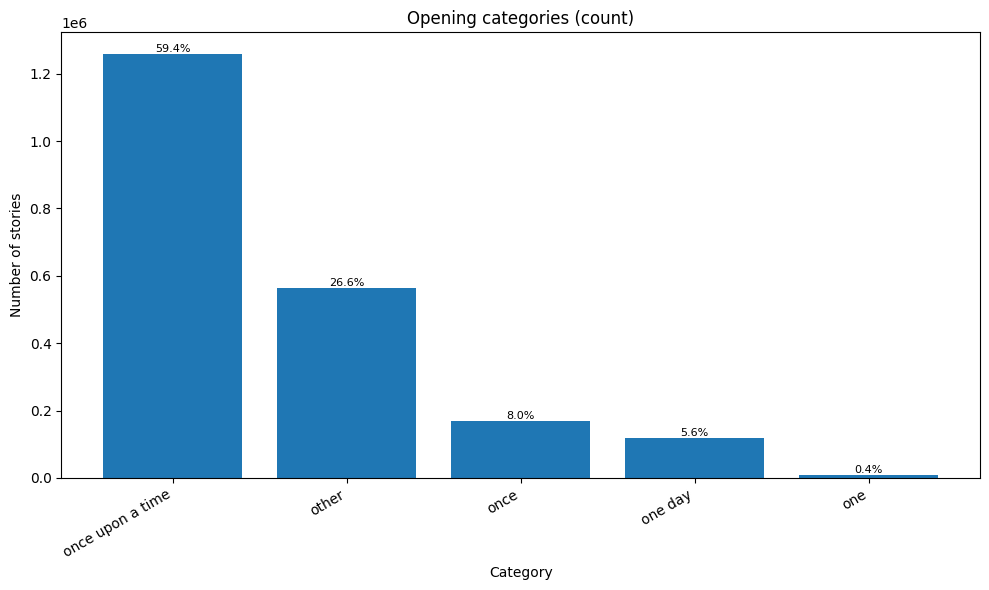

In [19]:
#  Overall opening categories for each 
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(cat_df)), cat_df['count'].tolist())
plt.xticks(range(len(cat_df)), cat_df['category'].tolist(), rotation=30, ha="right")
plt.title("Opening categories (count)")
plt.xlabel("Category")
plt.ylabel("Number of stories")
for bar, pct in zip(bars, cat_df['percent'].tolist()):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f"{pct:.1f}%", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

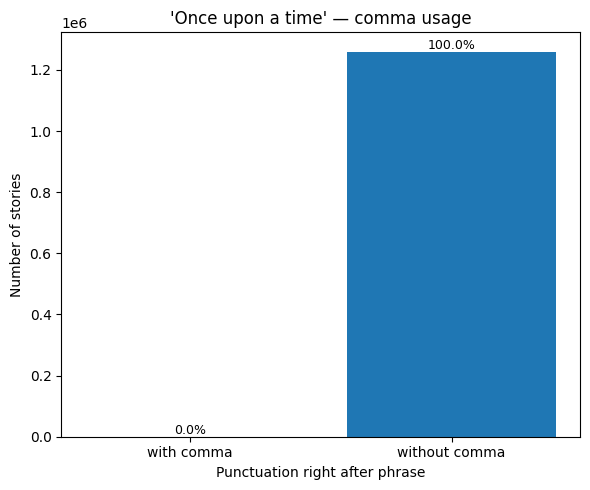

In [21]:
#  'Once upon a time' comma breakdown
if ouat_total:
    plt.figure(figsize=(6, 5))
    bars2 = plt.bar([0,1], ouat_df['count'].tolist())
    plt.xticks([0,1], ouat_df['comma'].tolist())
    plt.title("'Once upon a time' — comma usage")
    plt.xlabel("Punctuation right after phrase")
    plt.ylabel("Number of stories")
    for bar, pct in zip(bars2, ouat_df['percent'].tolist()):
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h, f"{pct:.1f}%", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()

# Analyzing number of words per story

In [22]:
word_counts = []
for story in tqdm(stream_stories(DATA_PATH), desc="Counting words per story"):
    # simple split on whitespace; fine for TinyStories
    n_words = len(story.split())
    word_counts.append(n_words)

print(f"Processed {len(word_counts):,} stories.")
print(f"Shortest: {min(word_counts)} words, longest: {max(word_counts)} words")

Counting words per story: 2119489it [00:35, 59023.58it/s]

Processed 2,119,489 stories.
Shortest: 5 words, longest: 963 words


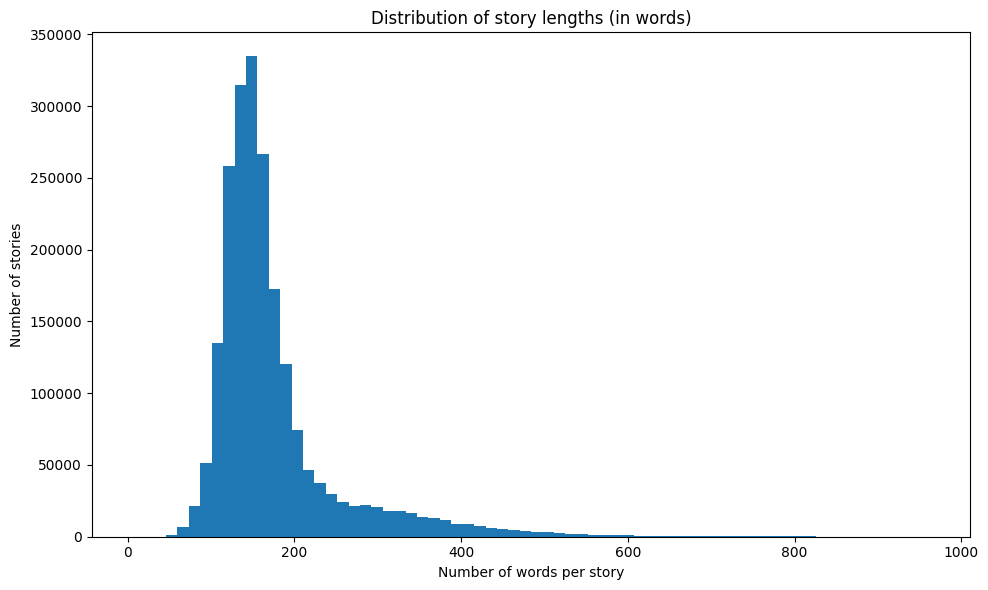

In [23]:
plt.figure(figsize=(10,6))
plt.hist(word_counts, bins=70)  # specify how many bins
plt.title("Distribution of story lengths (in words)")
plt.xlabel("Number of words per story")
plt.ylabel("Number of stories")
plt.tight_layout()
plt.show()


Most frequent character like Name in All Stories

In [24]:
NAME_RE = re.compile(r"\b[A-Z][a-z]+\b")

# common sentence starters or stopwords to ignore
STOP_WORDS = {
    "The", "A", "An", "Once", "One", "When", "If", "It", "In", "On", "At",
    "After", "Before", "As", "But", "And", "So", "Then", "There", "This",
    "That", "He", "She", "They", "His", "Her", "Their", "I", "We", "You",
    "My", "Our", "Your"
}

def extract_names(text: str):
    """Return all candidate capitalized names in a story."""
    return [m for m in NAME_RE.findall(text) if m not in STOP_WORDS]


In [25]:
# Count names over all stories 
name_counts = Counter()

for story in tqdm(stream_stories(DATA_PATH), desc="Scanning for names"):
    for name in extract_names(story):
        name_counts[name] += 1 

print(f"Unique candidate names: {len(name_counts):,}")


Scanning for names: 2119489it [00:54, 38747.17it/s]

Unique candidate names: 16,166


In [27]:
TOP_N = 25
top_names = name_counts.most_common(TOP_N)

for i, (n, c) in enumerate(top_names[:15], 1):
    print(f"{i:>2}. {n:<15} {c:>8,}")

 1. Lily            3,062,820
 2. Tom             1,152,883
 3. Ben             1,122,612
 4. Timmy            902,224
 5. Tim              608,509
 6. Mom              569,059
 7. Sam              486,361
 8. Anna             481,405
 9. Max              474,393
10. Jack             372,600
11. Let              342,056
12. Suddenly         337,620
13. Mia              331,225
14. Sara             331,045
15. From             319,619


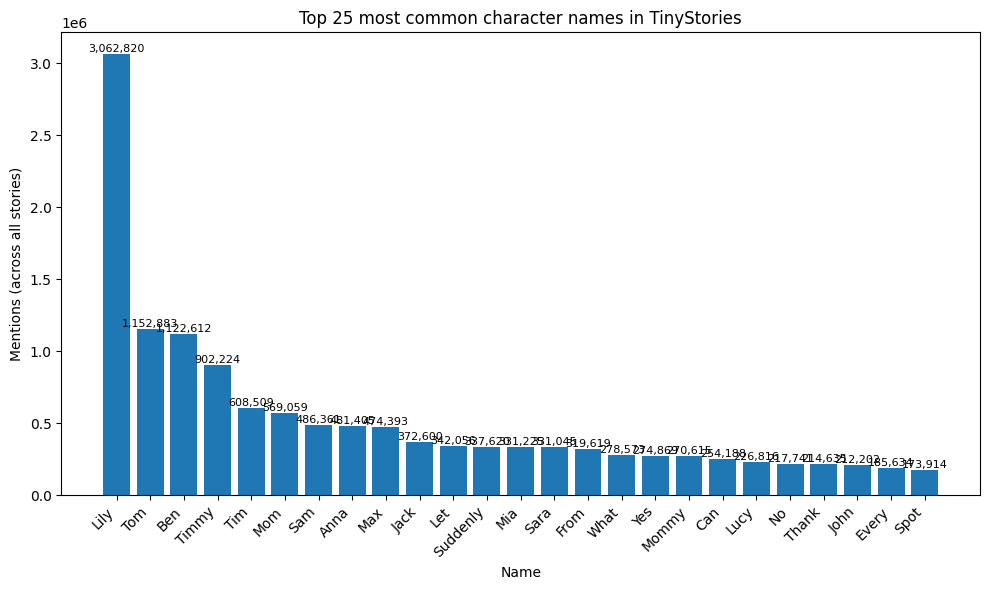

In [28]:
# Plot 
names  = [n for n, c in top_names]
counts = [c for n, c in top_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(names)), counts)
plt.xticks(range(len(names)), names, rotation=45, ha="right")
plt.title(f"Top {TOP_N} most common character names in TinyStories")
plt.xlabel("Name")
plt.ylabel("Mentions (across all stories)")

for bar, (n, c) in zip(bars, top_names):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{c:,}", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

In [29]:

try:
    from nltk.corpus import names
    male_names = set(names.words('male.txt'))
    female_names = set(names.words('female.txt'))
except:
    # fallback if nltk not installed or data missing
    male_names = {"Tom", "Sam", "Timmy", "Tim" ,"Jack", "Max", "Ben", "John", "Alex", "Luke", "Adam", "James"}
    female_names = {"Lily", "Anna", "Mom", "Lucy", "Mommy", "Emma", "Sophie", "Sara", "Mia", "Ella", "Mary", "Kate"}


In [30]:
NAME_RE = re.compile(r"\b[A-Z][a-z]+\b")

NON_NAMES = {
    "The","A","An","Once","One","Two","Three","Four","Five","Six","Seven","Eight","Nine","Ten",
    "When","If","It","In","On","At","After","Before","As","But","And","So","Then","There","This",
    "That","He","She","They","His","Her","Their","I","We","You","My","Our","Your",
    "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday",
    "Morning","Night","Day","Sun","Moon","Sky","Tree","Ball","House","Park","Forest","Friend"
}


In [31]:
def extract_person_names(text: str):
    """Return all candidate names (capitalized words, filtered)."""
    return [w for w in NAME_RE.findall(text) if w not in NON_NAMES]


In [32]:
# Count male vs female names 
gender_counts = Counter()

for story in tqdm(stream_stories(DATA_PATH), desc="Analyzing gender of names"):
    for name in extract_person_names(story):
        if name in male_names:
            gender_counts["male"] += 1
        elif name in female_names:
            gender_counts["female"] += 1
        else:
            gender_counts["unknown"] += 1

total_known = gender_counts["male"] + gender_counts["female"]
total_all   = sum(gender_counts.values())

male_pct = gender_counts["male"] / total_known * 100 if total_known else 0
female_pct = gender_counts["female"] / total_known * 100 if total_known else 0
unknown_pct = gender_counts["unknown"] / total_all * 100 if total_all else 0

print(f"\n--- Gender Distribution (among detected names) ---")
print(f"Male names:   {gender_counts['male']:,} ({male_pct:.1f}%)")
print(f"Female names: {gender_counts['female']:,} ({female_pct:.1f}%)")
print(f"Unknown/neutral: {gender_counts['unknown']:,} ({unknown_pct:.1f}% of all tokens)\n")


Analyzing gender of names: 2119489it [00:55, 37890.67it/s]


--- Gender Distribution (among detected names) ---
Male names:   5,367,106 (49.6%)
Female names: 5,446,836 (50.4%)
Unknown/neutral: 11,722,369 (52.0% of all tokens)



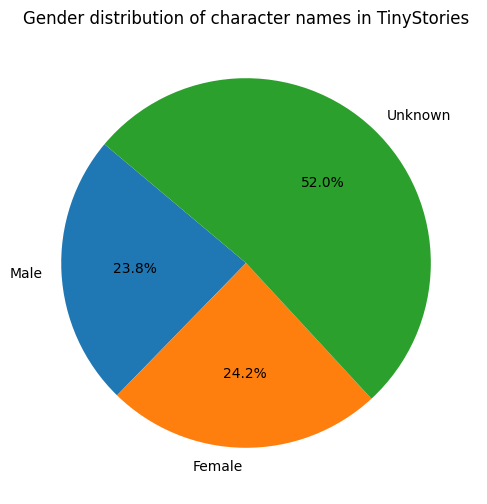

In [33]:
labels = ["Male", "Female", "Unknown"]
sizes = [gender_counts["male"], gender_counts["female"], gender_counts["unknown"]]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Gender distribution of character names in TinyStories")
plt.show()

EXTRA WORK: 

Inorder to the this paper "TinyStories" from Eldan et al. 2023 is not labeled with Categories, but if we want to know "How many categories", we have to detect them. 

We can scan all the stories for recuring topic words like family, magic, moral, friendship- school, adventure- travel and animal

In [34]:
CATEGORIES = {
    "animals": {"cat", "dog", "bird", "rabbit", "fish", "frog", "bear", "lion", "tiger", "monkey", "dino", "dinosaur"},
    "family": {"mom", "dad", "mother", "father", "sister", "brother", "baby", "grandma", "grandpa", "grandmother", "grandfather", "boy", "douther"},
    "magic": {"magic", "fairy", "wizard", "spell", "dragon", "castle", "king", "queen", "prince", "princess"},
    "friendship": {"friend", "play", "share", "together", "help", "happy"},
    "school": {"teacher", "school", "class", "learn", "book", "study", "kindergarten"},
    "adventure": {"journey", "mountain", "forest", "river", "sea", "explore"},
    "moral_lesson": {"kind", "good", "bad", "help", "share", "honest"},
    "travel": {"car", "bus", "bicycle", "train", "airplane"}
}

In [35]:
def detect_categories(story: str):
    story_lower = story.lower()
    matched = [cate for cate, kws in CATEGORIES.items() if any(kw in story_lower for kw in kws)]
    return matched if matched else ["other"]


In [36]:
cat_counts = Counter()

for story in tqdm(stream_stories(DATA_PATH), desc="Detecting categories"):
    for cat in detect_categories(story):
        cat_counts[cat] += 1

Detecting categories: 2119489it [01:36, 21896.09it/s]


In [37]:
total = sum(cat_counts.values())
print("\n=== Story Category Distribution ===")
for cat, count in cat_counts.most_common():
    print(f"{cat:<15} {count:>6,} ({count/total*100:5.1f}%)")

print(f"\n Sum of stories analyzed: {total:,}")
print(f"Detected categories: {len(cat_counts)}")


=== Story Category Distribution ===
friendship      1,888,919 ( 26.0%)
family          1,161,463 ( 16.0%)
moral_lesson    1,144,098 ( 15.8%)
travel          905,438 ( 12.5%)
magic           684,635 (  9.4%)
animals         664,358 (  9.2%)
school          400,106 (  5.5%)
adventure       394,301 (  5.4%)
other           12,316 (  0.2%)

 Sum of stories analyzed: 7,255,634
Detected categories: 9


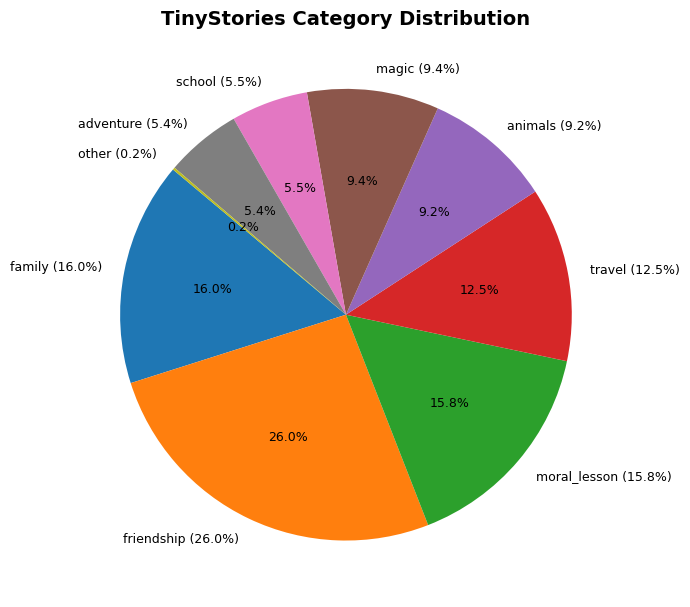

In [38]:
if not cat_counts:
    print("⚠️ No category counts found. Run the category counting cell first.")
else:
    # Prepare data
    labels = list(cat_counts.keys())
    sizes = list(cat_counts.values())
    total = sum(sizes)
    percentages = [s / total * 100 for s in sizes]

    # Create pie chart
    plt.figure(figsize=(7, 7))
    wedges, texts, autotexts = plt.pie(
        sizes,
        labels=[f"{l} ({p:.1f}%)" for l, p in zip(labels, percentages)],
        autopct="%1.1f%%",
        startangle=140,
        textprops={'fontsize': 9}
    )

    # Aesthetic settings
    plt.title("TinyStories Category Distribution", fontsize=14, weight="bold")
    plt.tight_layout()
    plt.show()